In [1]:
import scvi
import scanpy as sc
import pandas as pd
import numpy as np

Global seed set to 0


In [2]:
import matplotlib.pyplot as plt

In [3]:
import anndata

In [4]:
import os

In [5]:
import random

In [6]:
from pyscenic.aucell import aucell
from pyscenic.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

#### Load data

In [11]:
adata = sc.read('../../lagringshotellet/Users/Herman/data/zenodo/reference_nk.h5ad')

#### Train scVI model

In [56]:
scvi.model.SCVI.setup_anndata(adata,
                                batch_key='batch')

/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [57]:
scvi_model = scvi.model.SCVI(adata,
                        n_latent=20,#n_latent=40,
                        n_layers=2,
                        gene_likelihood = "nb")

In [58]:
scvi_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 158/158: 100%|██████████| 158/158 [20:49<00:00,  8.29s/it, loss=2.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=158` reached.


Epoch 158/158: 100%|██████████| 158/158 [20:49<00:00,  7.91s/it, loss=2.52e+03, v_num=1]


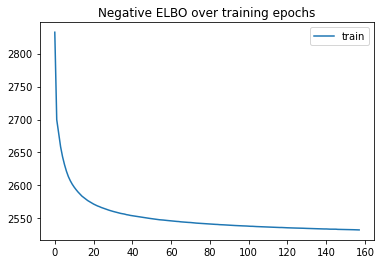

In [59]:
plt.plot(scvi_model.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

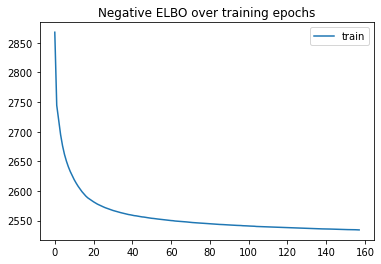

In [65]:
plt.plot(scvi_model.history["elbo_train"], label="train")
#plt.plot(vae.history["elbo_validation"], label="val")
plt.title("Negative ELBO over training epochs")
#plt.ylim(1100, 1500)
plt.legend()

In [61]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

In [62]:
sc.pp.neighbors(adata, use_rep="X_scVI")

#### Normalization

In [74]:
adata_norm = adata.copy()

In [75]:
sc.pp.normalize_total(adata_norm, target_sum=1e4)
sc.pp.log1p(adata_norm)

In [76]:
adata.layers['norm'] = adata_norm.X

#### PAGA

In [78]:
subset_only_paga = sc.tl.paga(adata, groups='subset_only', copy=True)

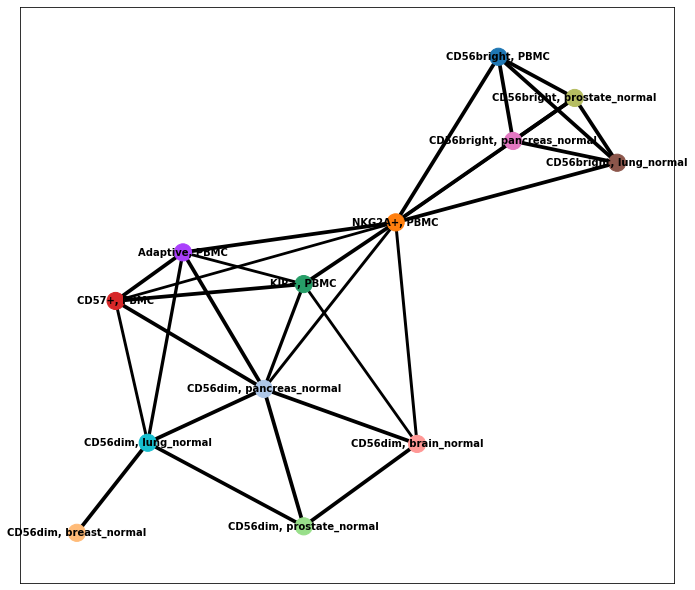

In [ ]:
sc.pl.paga(adata, node_size_power=0,export_to_gexf=True, edge_width_scale=0.5, 
           node_size_scale = 2, threshold=0.7, layout='fa', )

#### UMAP

In [100]:
sc.tl.umap(adata)#, init_pos='paga')

In [105]:
tr_genes = ['CD69', 'ITGAE', 'ITGA1', 'CXCR6', 'ZNF683', 'S1PR5', 'S1PR1', 'CD101', 'IKZF3']

In [106]:
signature_genes = [tr_genes]
signature_names = ['Tissue residency']

In [107]:
gene_sigs = [GeneSignature(name,genes) for (name,genes) in zip(signature_names, signature_genes)]

In [108]:
exp_df = adata.to_df()

In [112]:
auc_mtx = aucell(exp_df, gene_sigs, num_workers=4)

In [113]:
adata.obs[[x + '_auc' for x in auc_mtx.columns]] = auc_mtx.to_numpy()

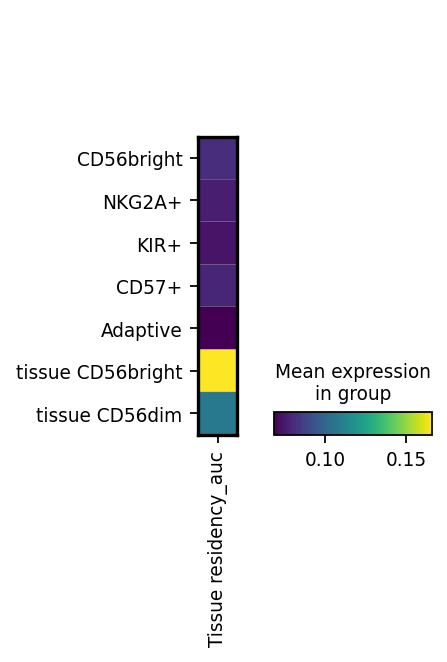

In [81]:
sc.pl.matrixplot(adata, 'Tissue residency_auc', groupby='subset_only', save='tr_auc_all_reference.pdf')

In [130]:
connectivities_df = pd.DataFrame(subset_source_low_paga.uns['paga']['connectivities'].todense(), 
                                 index=subset_source_low_paga.obs['low_res_subset_source'].cat.categories, columns=subset_source_low_paga.obs['low_res_subset_source'].cat.categories)

In [132]:
mask = np.zeros_like(connectivities_df, dtype='bool')
mask[np.triu_indices_from(mask)] = True

In [133]:
annot = np.diag(np.diag(connectivities_df.values,-1),-1)
annot = np.round(annot,2)
annot = annot.astype('str')
annot[annot>'0.1']=''

In [134]:
font = {'family' : 'Areal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)

In [135]:
import seaborn as sns

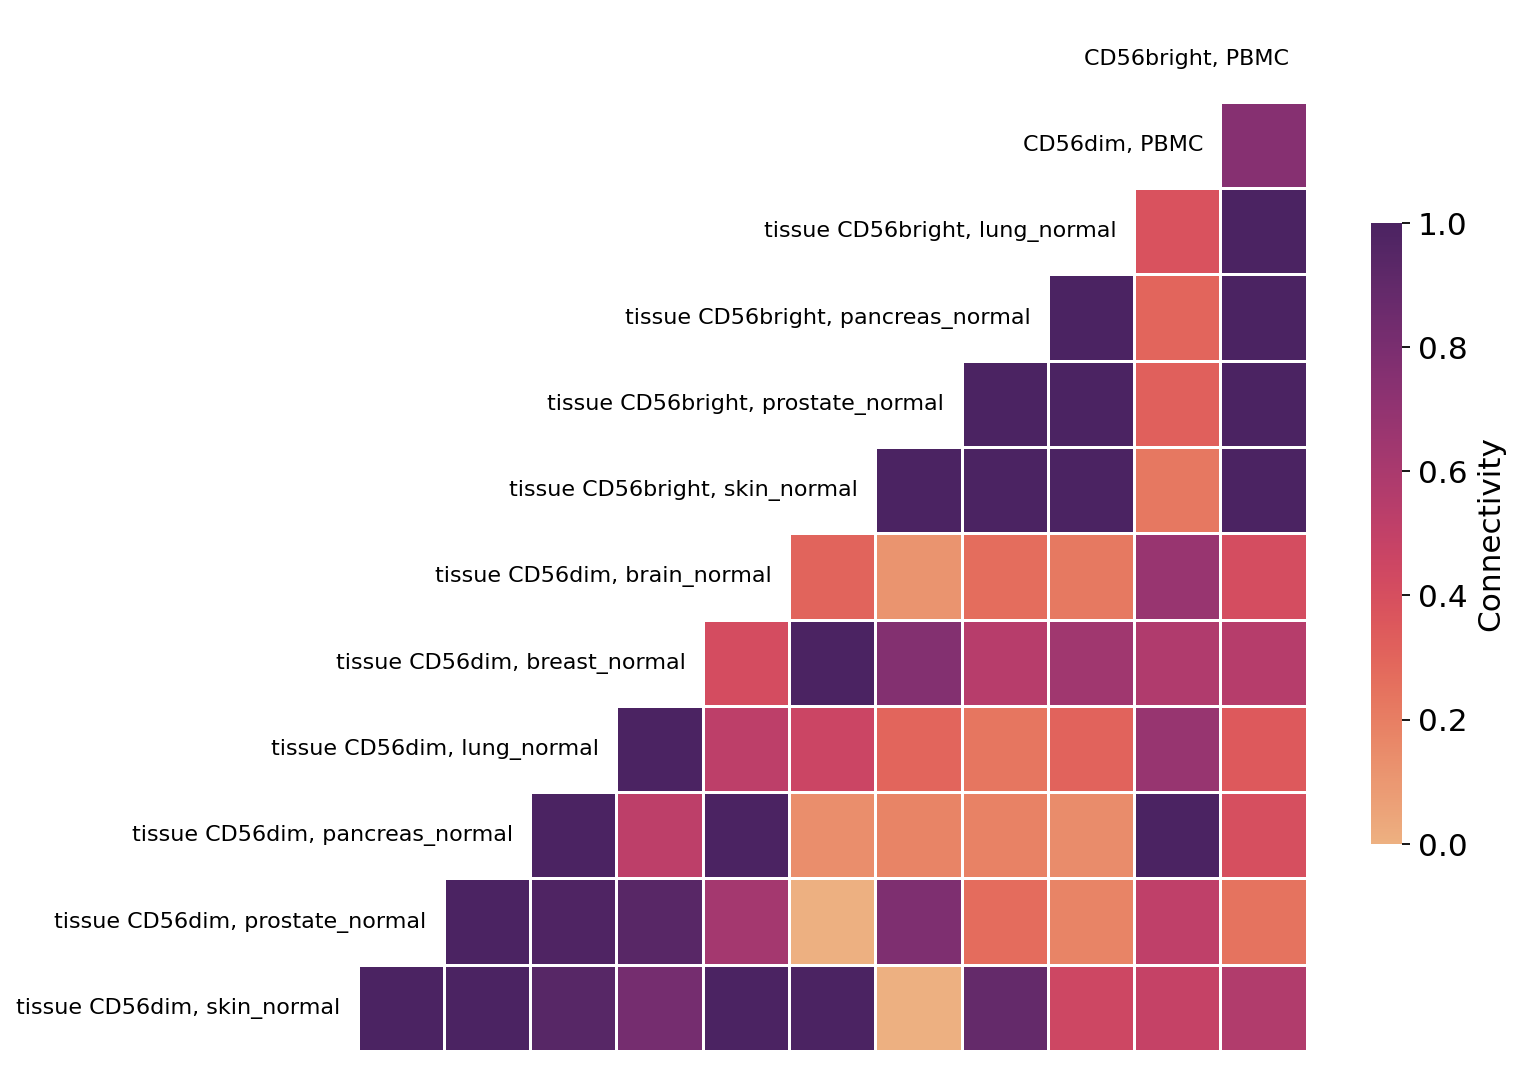

In [136]:
up_triang = np.triu(np.ones_like(connectivities_df)).astype(bool)
ax = sns.heatmap(connectivities_df, cmap='flare', xticklabels=False, yticklabels=False, square=True,
                 linecolor='white', linewidths=0.5,
                 cbar=True, mask=up_triang, cbar_kws={'shrink': 0.4, 'pad': 0.05, 'label': 'Connectivity'})
ax.invert_xaxis()
for i, label in enumerate(connectivities_df.index):
    ax.text(i + 0.2, i + 0.5, label, ha='right', va='center')
plt.tight_layout()
plt.savefig(os.path.join(sc.settings.figdir, 'subset_low_pbmc_normal_connectivities.pdf'), bbox_inches='tight')

#### Save models and adata

In [ ]:
scvi_model.save('pb_tissue_normal_ref_scvi', overwrite=True)

In [12]:
scvi_model = scvi.model.SCVI.load('pb_tissue_normal_ref_scvi', adata=adata)

INFO     File ../../lagringshotellet/Users/Herman/data/zenodo/pb_tissue_normal_ref_scvi/model.pt already downloaded


INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO:absl:Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
/itf-fi-ml/home/hermankn/.local/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
